In [1]:
!unzip /content/drive/'My Drive'/celebdataset.zip -d /content/sample_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/Train/Train/168218.jpg  
  inflating: /content/sample_data/Train/Train/168502.jpg  
  inflating: /content/sample_data/Train/Train/168506.jpg  
  inflating: /content/sample_data/Train/Train/168533.jpg  
  inflating: /content/sample_data/Train/Train/168552.jpg  
  inflating: /content/sample_data/Train/Train/168789.jpg  
  inflating: /content/sample_data/Train/Train/169013.jpg  
  inflating: /content/sample_data/Train/Train/169032.jpg  
  inflating: /content/sample_data/Train/Train/169084.jpg  
  inflating: /content/sample_data/Train/Train/169180.jpg  
  inflating: /content/sample_data/Train/Train/169331.jpg  
  inflating: /content/sample_data/Train/Train/169335.jpg  
  inflating: /content/sample_data/Train/Train/169419.jpg  
  inflating: /content/sample_data/Train/Train/169551.jpg  
  inflating: /content/sample_data/Train/Train/169602.jpg  
  inflating: /content/sample_data/Train/Train/169684.jpg  
  inf

In [0]:
data_dir = '/content/sample_data/Train'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
from torchvision import datasets
from torchvision import transforms

In [0]:
def get_dataloader(batch_size, image_size, data_dir='/content/sample_data/Train'):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    return data_loader

In [0]:
batch_size = 64
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size)

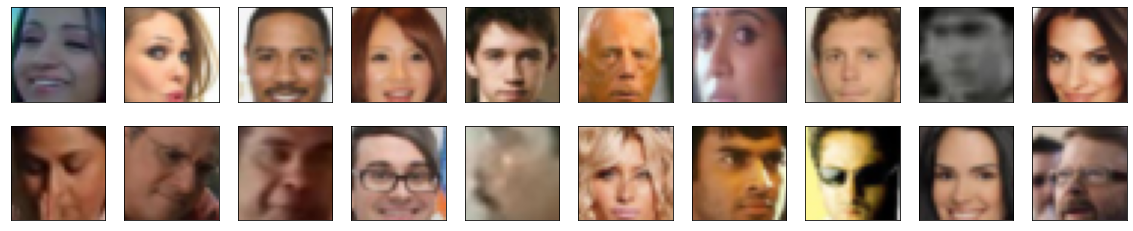

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
def scale(x, feature_range=(-1, 1)):   
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2,kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(conv_dim*4)
        self.conv4 = nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(conv_dim*8)
        self.conv5 = nn.Conv2d(conv_dim*8, conv_dim*16, kernel_size=4, stride=2, padding=1, bias=False)
        self.fc = nn.Linear(conv_dim*4*4, 1)
        

    def forward(self, x):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.batch_norm3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.batch_norm4(self.conv4(x)), 0.2)
        x = self.conv5(x)
        # flatten
        x = x.view(-1, self.conv_dim*4*4)
        # final output layer
        x = F.sigmoid(self.fc(x))
        
        return x


In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4 )
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        self.dropout = nn.Dropout(0.5)
        
        

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.tanh(self.t_conv3(x))
        
        return x


In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)

In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [15]:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_c

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels) 
    return loss

In [0]:
import torch.optim as optim

lr=0.0005
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.3, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.3, 0.999))

In [0]:
def train(D, G, n_epochs, print_every=50):

    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
\
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))



        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() 

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [21]:

import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [22]:

n_epochs = 10
losses = train(D, G, n_epochs=n_epochs)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   10] | d_loss: 1.3723 | g_loss: 4.9322
Epoch [    1/   10] | d_loss: 0.5075 | g_loss: 5.1341
Epoch [    1/   10] | d_loss: 0.5839 | g_loss: 2.7108
Epoch [    1/   10] | d_loss: 1.1671 | g_loss: 0.2053
Epoch [    1/   10] | d_loss: 0.8094 | g_loss: 1.5916
Epoch [    1/   10] | d_loss: 0.6821 | g_loss: 1.2614
Epoch [    1/   10] | d_loss: 0.9278 | g_loss: 1.3278
Epoch [    1/   10] | d_loss: 0.6815 | g_loss: 1.3695
Epoch [    1/   10] | d_loss: 1.9278 | g_loss: 0.3463
Epoch [    1/   10] | d_loss: 0.8925 | g_loss: 1.3227
Epoch [    1/   10] | d_loss: 0.7046 | g_loss: 2.3506
Epoch [    1/   10] | d_loss: 0.9430 | g_loss: 2.4018
Epoch [    1/   10] | d_loss: 1.1952 | g_loss: 0.7944
Epoch [    1/   10] | d_loss: 0.8991 | g_loss: 2.1697
Epoch [    1/   10] | d_loss: 1.0049 | g_loss: 0.6968
Epoch [    1/   10] | d_loss: 1.0429 | g_loss: 1.1512
Epoch [    1/   10] | d_loss: 1.0948 | g_loss: 2.2039
Epoch [    1/   10] | d_loss: 1.2747 | g_loss: 0.8244
Epoch [    1/   10] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


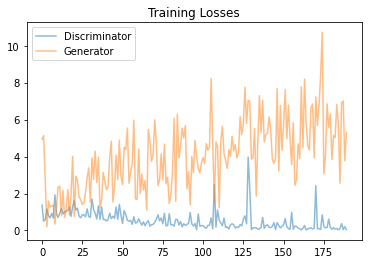

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend();

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

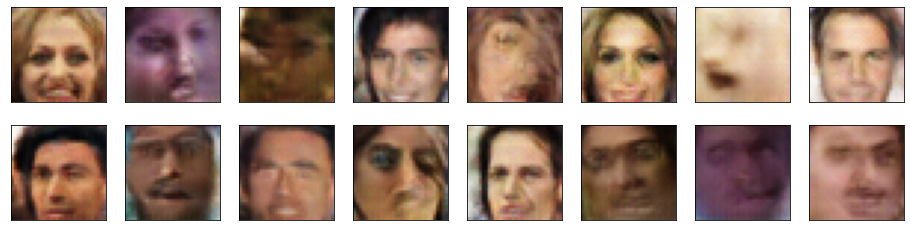

In [35]:
_ = view_samples(-1, samples)